<a href="https://colab.research.google.com/github/mattlamachado/King_County_DNC/blob/main/34012_Roof_Imoveis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# King County opção de investimento
5 imóveis que ela deveria investir e o porquê e quais 5 você não recomendaria o investimento de jeito nenhum.

In [43]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# import geopandas as gpd

roof = pd.read_csv('kingcounty/kc_house_data.csv')

In [44]:
roof.info()
roof_c = roof.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  int64  
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [45]:
roof_c.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# Limpeza do dado

Conhecendo alguns parâmetros básicos como os limites das variáveis:

In [46]:
display(roof_c.agg(['min', 'mean', 'max']))

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
min,1.000102e+06,2.014050e+07,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,...,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
mean,4.580302e+09,2.014390e+07,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,...,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
max,9.900000e+09,2.015053e+07,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,...,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [47]:
print(set(roof_c['bedrooms']), set(roof_c['bathrooms']), 
set(roof_c['floors']), set(roof_c['waterfront']), set(roof_c['view']),
set(roof_c['condition']), set(roof_c['grade']) 
, sep = '\n')

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 33}
{0.75, 1.0, 2.0, 2.25, 3.0, 4.5, 1.5, 2.5, 1.75, 2.75, 3.25, 4.0, 3.5, 4.75, 5.0, 0.0, 3.75, 8.0, 4.25, 5.25, 5.5, 5.75, 1.25, 6.0, 0.5, 6.75, 6.25, 7.5, 7.75, 6.5}
{1.0, 2.5, 2.0, 3.0, 1.5, 3.5}
{0, 1}
{0, 1, 2, 3, 4}
{1, 2, 3, 4, 5}
{1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}


### Observações

Como a codificação não está especificada na documentação, foi decidido reduzir todos os valores decimais de 'floors' e 'bathrooms' para o número inteiro anterior, apesar de essas características não terem sido escolhidas para a composição do SCORE.

In [48]:
roof_c.loc[:,['bathrooms', 'floors']] = np.floor(roof_c.loc[:,['bathrooms', 'floors']])

print(set(roof_c['bedrooms']), set(roof_c['bathrooms']), 
set(roof_c['floors']), set(roof_c['waterfront']), set(roof_c['view']),
set(roof_c['condition']), set(roof_c['grade']) 
, sep = '\n')



{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 33}
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0}
{1.0, 2.0, 3.0}
{0, 1}
{0, 1, 2, 3, 4}
{1, 2, 3, 4, 5}
{1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13}


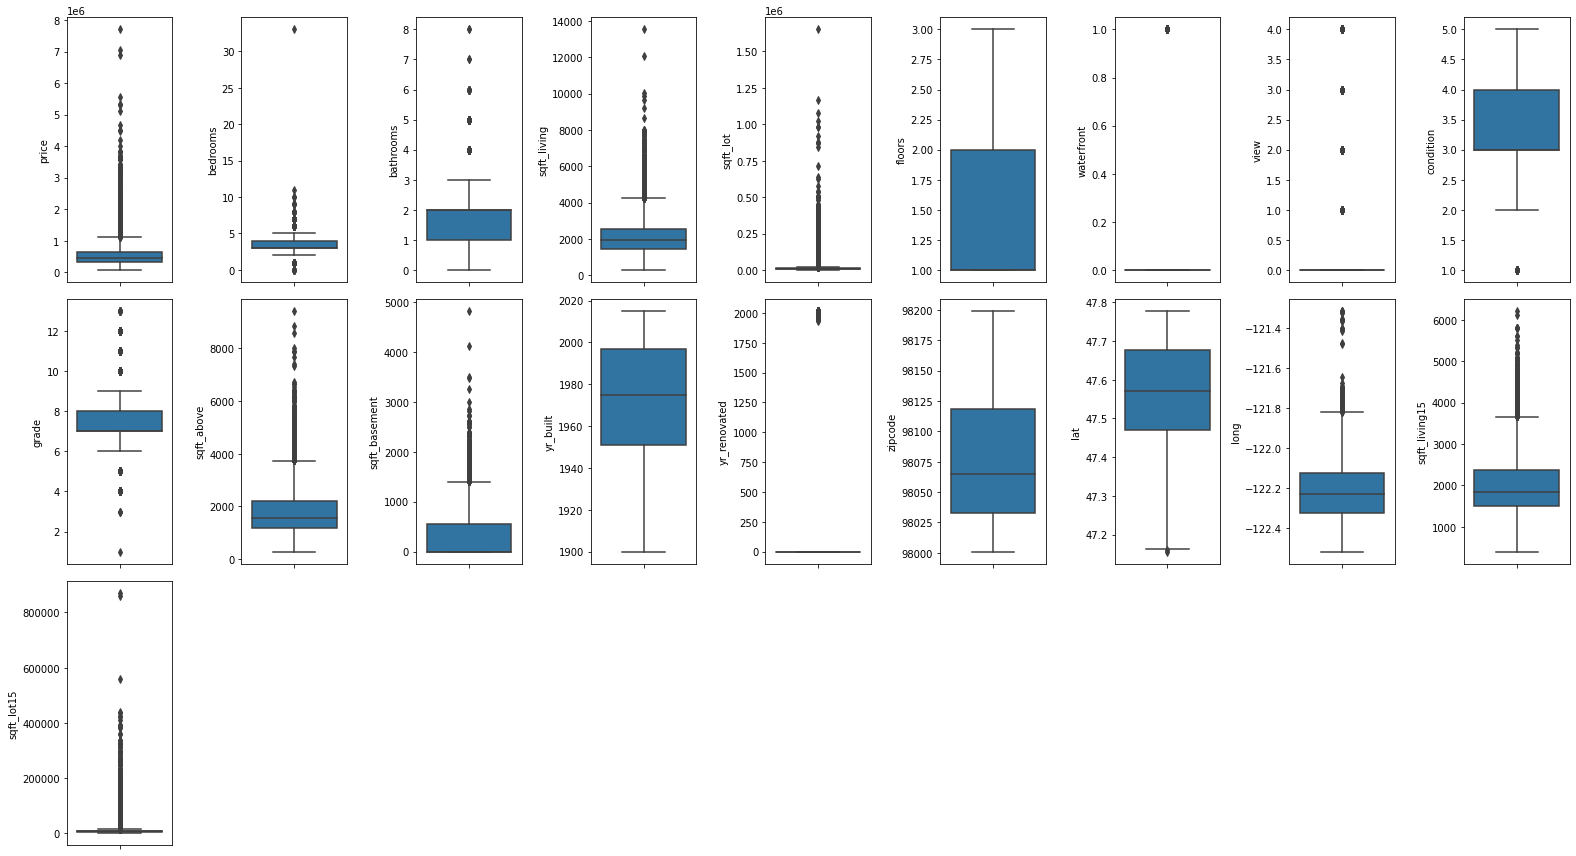

In [49]:
plt.figure(figsize=(22,12), )

for n, i in enumerate(roof_c.columns[2:]):
    plt.subplot(3, 9, n+1)
    sns.boxplot(y = roof_c.loc[:,i], orient='v')
    # plt.yscale('log')

plt.tight_layout()
plt.show()

# Diferentes ZIPcodes de King County

A região de abrangência de ZIPcodes (CEP) pode pegar desde a escala de ruas até cidades inteiras, neste caso optou-se por plotar um mapa discriminado por valores de ZIPcode, e observou-se que pode-se inferir que os ZIPcodes representam bairros de King County, a partir disso o SCORE vai ser montado em cima de desvio padrão e média de cada bairro.

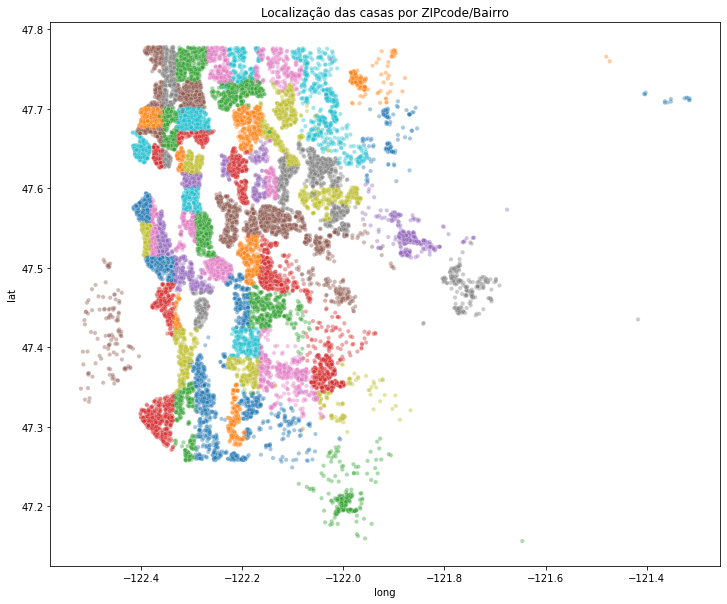

In [50]:
plt.figure(figsize=[12,10])
plt.title('Localização das casas por ZIPcode/Bairro')
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, alpha=0.4, legend=False, 
hue = roof_c['zipcode'], palette='tab10')

plt.show()

## Insights
- Calcule o lucro/ perda de investimento caso o imóvel seja vendido mais de uma vez naquele período.


## Definição de $\frac{Preco}{pé^2}$
Definição do preço por pé<sup>2</sup> dá uma ideia melhor do custo pra adquirir o imóvel excluindo o efeito do tamanho do imóvel.

In [51]:
roof_c['price_sqft'] = roof_c['price']/roof_c['sqft_living']
print(roof_c['price_sqft'])

0        188.050847
1        209.338521
2        233.766234
3        308.163265
4        303.571429
            ...    
21608    235.294118
21609    173.160173
21610    394.216667
21611    250.000000
21612    318.627451
Name: price_sqft, Length: 21613, dtype: float64


## Cálculo do Z score do \$/pé<sup>2</sup>
$z~score = \frac{(valor - média_{bairro})}{desvpad_{bairro}}$

Optou-se por realizar o cálculo do z-score que é um valor que representa quão afastados da média estão os valores em unidades de desvio padrão.


Primeiramente, o z-score foi calculado considerando a média e desvio padrão para todos os imóveis, consequentemente, os imóveis das áreas mais ricas ficaram supervalorizados, mas quando faz-se o z-score comparando o valor com os imóveis de mesmo ZIPcode, a realidade muda bastante, oportunidades de investimentos em áreas nobres passam a surgir, pois em comparação as redondezas, esses imóveis estão com um preço atrativo.

## Z-SCORE método geral

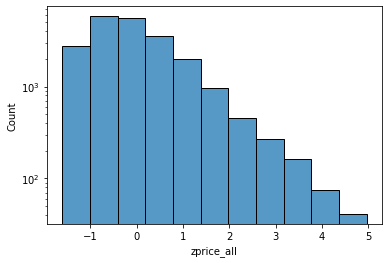

In [52]:
roof_c['zprice_all'] = pd.Series( (roof_c['price_sqft'] - (np.mean(roof_c['price_sqft']))) / np.std(roof_c['price_sqft']))

plt.figure()
sns.histplot(roof_c['zprice_all'], bins=11)
plt.yscale('log')
plt.show()


## Z-SCORE compartimentado por bairros (ZIPcode)

In [53]:
for i,n in enumerate(roof_c['zipcode']):
    roof_c.loc[i, 'zprice'] = (roof_c.loc[i, 'price_sqft'] - np.mean(roof_c['price_sqft'][roof_c['zipcode'] == n])) / np.std(roof_c['price_sqft'][roof_c['zipcode'] == n], ddof=0)

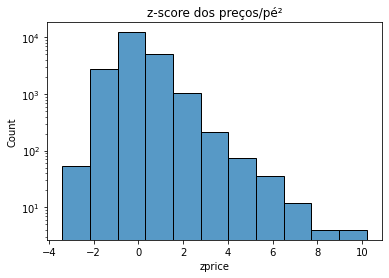

In [54]:
plt.figure()
plt.title('z-score dos preços/pé\u00b2')
sns.histplot(roof_c['zprice'], bins=11)
plt.yscale('log')
plt.show()

## Cálculo da diferença do tamanho do imóvel em relação a vizinhança
Quão discrepante for o imóvel, para mais ou para menos em relação a vizinhança, menor vai ser o score final, assumindo que nenhum comprador queira adquirir um imóvel fora dos padrões da vizinhança.

O Valor foi elevado ao quadrado para o efeito da discrepância não ser linear.

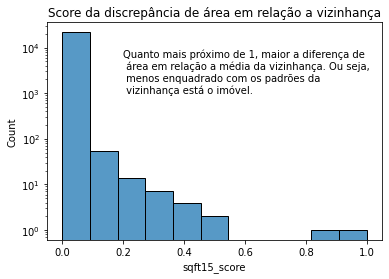

In [55]:
roof_c['sqft15_score'] = np.abs(roof_c['sqft_living'] - roof_c['sqft_living15'])**2
roof_c['sqft15_score'] /= max(roof_c['sqft15_score'])

plt.figure()
plt.title('Score da discrepância de área em relação a vizinhança')
sns.histplot(roof_c['sqft15_score'], bins=11)
plt.yscale('log')
anotacao = 'Quanto mais próximo de 1, maior a diferença de \n área em relação a média da vizinhança. Ou seja, \n menos enquadrado com os padrões da \n vizinhança está o imóvel.'
plt.annotate(anotacao, (0.2, 1000), )
plt.show()

## Contrução do Score do imóvel

Dividindo as variáves pelos seus ranges, trazendo todas para a mesma escala entre 0-1:


$roof\_c['SCORE'] =$ 

<p style="text-align: center;"> (( (roof_c['waterfront'])*pesos['waterfront'] + (roof_c['view']/4)*pesos['view'] + ((roof_c['condition']-1)/4)*pesos['condition'] + ((roof_c['grade']-1)/12)*pesos['grade'] + ((roof_c['yr_built'] - 1900)/115)*pesos['yr_built'] + ((n - 1900)/115)*pesos['yr_renovated'] - (roof_c['sqft15_score'])*pesos['sqft15_score']) </p>
<p style="text-align: center;">__________________________________________________________________</p>
<p style="text-align: center;">(roof_c['zprice'] + abs(min(roof_c['zprice'])) + 1))</p>



As variáveis do numerador ***aumentam o grau de atratividade*** de investimento em um imóvel, exceto ***'sqft15_score'***, o ***z-score*** representa quão distante da média o \$/m<sup>2</sup> está em relação aos bairros de King County. ***Dividindo o score pelo z-score***, os imóveis com maiores valores de z-score, ou seja, com ***\$/m<sup>2</sup> muito acima da média, estão superprecificadas e tem seu score reduzido proporcionalmente***, reduzindo a tratividade de investimento.

In [56]:
# definição dos pesos de cada fator:

pesos = dict({
    'waterfront':1.5,'view':1.2,
    'condition':2, 'grade':2,
    'yr_built':1, 'yr_renovated':0.5,
    'sqft15_score':1
})

In [57]:

roof_c['SCORE'] = ( (roof_c['waterfront'])*pesos['waterfront'] + (roof_c['view']/4)*pesos['view'] + ((roof_c['condition']-1)/4)*pesos['condition'] + ((roof_c['grade']-1)/12)*pesos['grade'] + ((roof_c['yr_built'] - 1900)/115)*pesos['yr_built'] - (roof_c['sqft15_score'])*pesos['sqft15_score'])

for i, n in enumerate(roof_c['yr_renovated']):
    if n != 0:
        roof_c.loc[i, 'SCORE'] += ((n - 1900)/115)*pesos['yr_renovated']

roof_c['SCORE'] /= (roof_c['zprice'] + abs(min(roof_c['zprice'])) + 1)

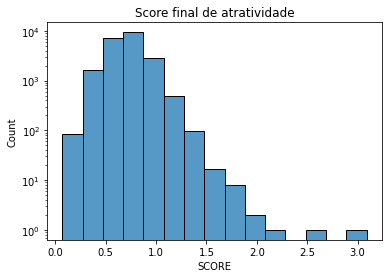

In [58]:
plt.figure()
plt.title('Score final de atratividade')
sns.histplot(roof_c['SCORE'], bins=15)
plt.yscale('log')
plt.show()

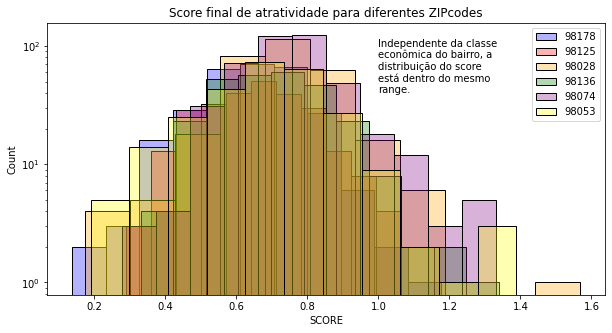

In [59]:
colors = ['blue', 'red', 'orange', 'green', 'purple', 'yellow']

plt.figure(figsize=(10,5))
plt.title('Score final de atratividade para diferentes ZIPcodes')

for i, x in enumerate(set(roof_c.loc[range(0,len(roof_c['zipcode']), 4000),'zipcode'])):
    sns.histplot(roof_c['SCORE'][roof_c['zipcode'] == x], bins=11, color=colors[i], alpha = 0.3)
plt.yscale('log')
plt.legend(roof_c['zipcode'])
msg = 'Independente da classe \neconômica do bairro, a \ndistribuição do score \nestá dentro do mesmo \nrange.'
plt.annotate(msg, (1,40))
plt.show()

## SCORE método antigo

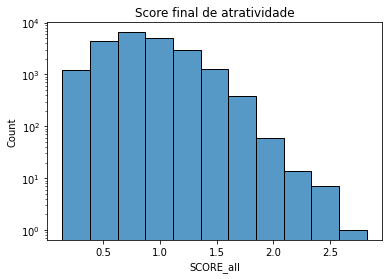

In [60]:
roof_c['SCORE_all'] = (( (roof_c['waterfront']) + (roof_c['view']/4) + (roof_c['condition']/5) + (roof_c['grade']/13) + ((roof_c['yr_built'] - 1900)/115) + ((roof_c['yr_renovated'])/2015)*0.5 - (roof_c['sqft15_score'])) / (roof_c['zprice_all'] + abs(min(roof_c['zprice_all'])) + 1))

plt.figure()
plt.title('Score final de atratividade')
sns.histplot(roof_c['SCORE_all'], bins=11)
plt.yscale('log')
plt.show()

In [61]:
columns = ['waterfront', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated', 'sqft15_score', 'zprice', 'SCORE']
roof_c[columns].agg(['min', 'mean', 'max'])

,waterfront,view,condition,grade,yr_built,yr_renovated,sqft15_score,zprice,SCORE
min,0.000000,0.000000,1.00000,1.000000,1900.000000,0.000000,0.000000,-3.406637e+00,0.068653
mean,0.007542,0.234303,3.40943,7.656873,1971.005136,84.402258,0.004895,1.841040e-17,0.715274
max,1.000000,4.000000,5.00000,13.000000,2015.000000,2015.000000,1.000000,1.019591e+01,3.089822


## 5 imóveis mais atrativos para investimento

Os imóveis mais atrativos para investimento apresentaram características variadas, não necessariamente precisam ter uma boa vista, ou uma qualidade de construção alta, apesar de no geral a condição e a qualidade do imóvel estarem de médio para bom, **o grande fator de atratividade foram os preços bem abaixo da média, apresentando boas oportunidades de investimento apesar de não serem imóveis excelentes**. Além de não serem construções tão antigas.

In [62]:
display(roof_c.loc[:,columns].sort_values('SCORE', axis=0, ascending=False, inplace=False).head())

,waterfront,view,condition,grade,yr_built,yr_renovated,sqft15_score,zprice,SCORE
326,0,0,3,9,1987,0,0.000033,-3.406637,3.089822
21372,0,2,3,10,2015,0,0.051392,-2.798331,2.517313
21050,0,4,3,12,2007,0,0.179331,-2.196254,2.164529
3844,0,0,3,7,2007,0,0.001356,-2.968844,2.037205
11436,0,0,3,7,2007,0,0.001531,-2.910999,1.958298


## 5 imóveis menos atrativos para investimento

Dentre os imóveis menos atrativos, podemos destacar algumas características em comum, por exemplo, imóveis muito antigos com pontuação de condição baixa, e qualidade dos materiais também baixa. Além disso possuem preço por pé<sup>2</sup> acima da média, mais do que 3 desvios padrões, **ou seja, são imóveis sobreprecificados, antigos e em condições ruins.**

In [63]:
display(roof_c.loc[:,columns].sort_values('SCORE', axis=0, ascending=True, inplace=False).head())

,waterfront,view,condition,grade,yr_built,yr_renovated,sqft15_score,zprice,SCORE
19452,0,0,1,1,1963,0,0.023424,3.231770,0.068653
13629,0,0,1,5,1932,0,0.006305,5.423579,0.095483
8623,0,0,2,4,1953,0,0.008057,6.132391,0.137851
5832,0,0,2,3,1950,0,0.002014,4.770025,0.137970
8606,0,0,3,5,1953,0,0.017210,10.080076,0.145673


## Localização dos 10 imóveis baseado na média de \$/pé<sup>2</sup> de todo o King County

In [64]:
top5_all = roof_c.sort_values('SCORE_all', axis=0, ascending=False, inplace=False).head()
bottom5_all = roof_c.sort_values('SCORE_all', axis=0, ascending=True, inplace=False).head()

plt.figure(figsize=[12,10])
plt.title('Localização do Top5 e Bottom5 imóveis')
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, 
alpha=0.9, legend=True, hue=roof_c['SCORE_all'], palette='viridis', hue_norm=(0,1.5))

top5 = plt.scatter(top5_all['long'], top5_all['lat'], c = 'red', s = 50)
bottom5 = plt.scatter(bottom5_all['long'], bottom5_all['lat'], c = 'navy', s = 50)
# plt.legend([top5, bottom5], roof_c['SCORE'])

plt.show()

## Localização dos 10 imóveis baseado na média de \$/pé<sup>2</sup> por cada ZIPcode de King County

De maneira geral, o SCORE independe da condição socio-econômica do bairro, pois leva em consideração a média do bairro, ou seja, imóveis com bons scores e preço por pé<sup>2</sup> abaixo da média são encontrados em todas as regiões.

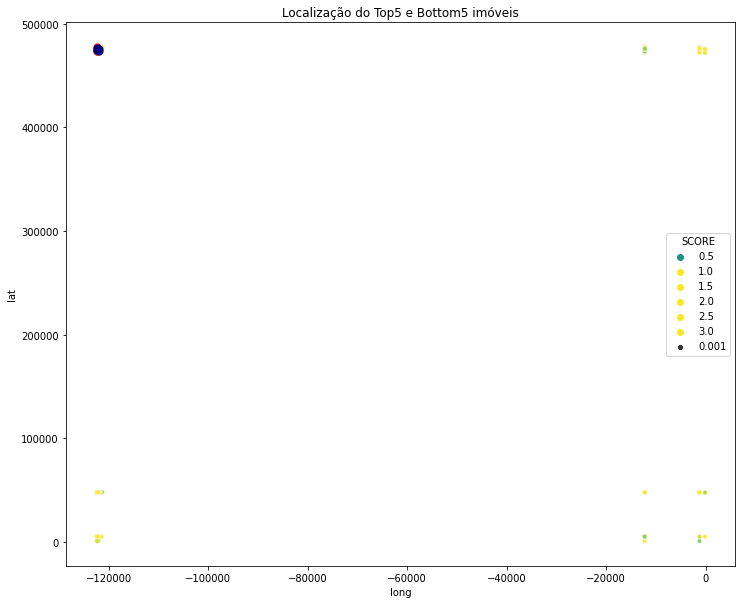

In [ ]:
top5 = roof_c.sort_values('SCORE', axis=0, ascending=False, inplace=False).head()
bottom5 = roof_c.sort_values('SCORE', axis=0, ascending=True, inplace=False).head()

plt.figure(figsize=[12,10])
plt.title('Localização do Top5 e Bottom5 imóveis')
sns.scatterplot(x = roof_c['long'], y = roof_c['lat'], size=0.001, 
alpha=0.9, legend=True, hue=roof_c['SCORE'], palette='viridis', hue_norm=(0,1.))

plt.scatter(top5['long'], top5['lat'], c = 'red', s = 50)
plt.scatter(bottom5['long'], bottom5['lat'], c = 'navy', s = 50)
# plt.legend(roof_c['SCORE'])


plt.show()

## extra

In [ ]:
justNum = roof_c.select_dtypes(include='number')
justNum.drop(inplace = True, columns=['id', 'bedrooms', 'bathrooms', 'waterfront', 'SCORE', 'SCORE_all', 'zprice', 'zprice_all', 'lat', 'long', 'zipcode', 'sqft15_score', 'yr_renovated'])


In [ ]:
w = roof_c[['grade', 'price_sqft', 'yr_built']].groupby('yr_built', as_index=False).agg('mean')
w

,yr_built,grade,price_sqft
0,1900,6.873563,1.818904e+04
1,1901,7.034483,1.259777e+04
2,1902,7.444444,2.366602e+04
3,1903,6.869565,1.647606e+03
4,1904,6.911111,8.643742e+03
...,...,...,...
111,2011,8.184615,4.032725e+05
112,2012,8.182353,1.739393e+05
113,2013,8.467662,5.280811e+05
114,2014,8.559928,1.144979e+06


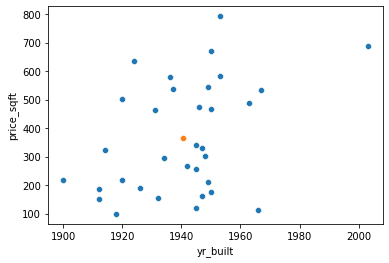

In [ ]:
y = roof_c[roof_c['grade']<5]
plt.figure()
sns.scatterplot(x = y['yr_built'], y = y['price_sqft'])
sns.scatterplot(x = [y['yr_built'].mean()], y =[ y['price_sqft'].mean()]);


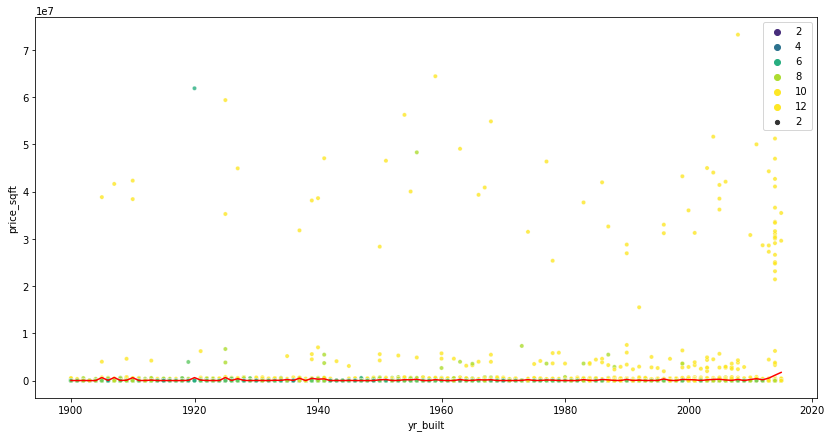

In [ ]:
 
y = roof_c[roof_c['grade']>0]
plt.figure(figsize=(14,7))
sns.scatterplot(x = y['yr_built'], y = y['price_sqft'], alpha=0.8, size=2, hue=roof_c['grade'], palette='viridis', hue_norm=(1,9))
sns.lineplot(x = w['yr_built'], y = w['price_sqft'], color='r')
plt.show()

In [ ]:
#duplicates = [x for x in roof_c['id'] if roof_c['id'].groupby(axis=0, level=0).count(x) > 1]
dup = pd.DataFrame(roof_c['id'].copy())
dup['n'] = 1
dup = dup.groupby('id', as_index=False).agg('sum')

duplicates = roof_c.iloc[:0,:]
display(duplicates)

for x,y in zip(dup['id'], dup['n']):
    if y > 1:
        for index,id in enumerate(roof_c['id']):
            if x == id:
                duplicates = pd.concat([duplicates, pd.DataFrame(roof_c.loc[index]).T], axis=0, ignore_index=True)

display(duplicates)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,price_sqft,zprice_all,zprice,sqft15_score,SCORE,SCORE_all


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,price_sqft,zprice_all,zprice,sqft15_score,SCORE,SCORE_all
0,1.000102e+06,20140916.0,280000.0,6.0,3.0,2400.0,9373.0,2.0,0.0,0.0,...,473262.0,-122214.0,2060.0,7316.0,116.666667,-0.067816,-1.072533,0.001531,1.248139,1.928211
1,1.000102e+06,20150422.0,300000.0,6.0,3.0,2400.0,9373.0,2.0,0.0,0.0,...,473262.0,-122214.0,2060.0,7316.0,125.000000,-0.067813,-0.813523,0.001531,1.118523,1.928203
2,7.200179e+06,20141016.0,150000.0,2.0,1.0,840.0,12750.0,1.0,0.0,0.0,...,47484.0,-122211.0,1480.0,6969.0,178.571429,-0.067789,-0.033384,0.005424,0.624653,1.273455
3,7.200179e+06,20150424.0,175000.0,2.0,1.0,840.0,12750.0,1.0,0.0,0.0,...,47484.0,-122211.0,1480.0,6969.0,208.333333,-0.067776,0.509231,0.005424,0.535852,1.273438
4,1.092004e+08,20140820.0,245000.0,3.0,175.0,1480.0,3900.0,1.0,0.0,0.0,...,472977.0,-122367.0,1830.0,6956.0,165.540541,-0.067795,-0.049700,0.001622,0.980371,2.032422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348,9.828200e+09,20150106.0,430000.0,2.0,1.0,700.0,4800.0,1.0,0.0,0.0,...,476147.0,-1223.0,1440.0,4800.0,614.285714,-0.067598,-0.092793,0.007251,0.679356,1.322209
349,9.834200e+09,20140716.0,350000.0,3.0,1.0,1790.0,3876.0,15.0,0.0,0.0,...,47575.0,-122288.0,1360.0,4080.0,195.530726,-0.067782,-0.136159,0.002448,0.956113,1.570721
350,9.834200e+09,20150210.0,615000.0,3.0,1.0,1790.0,3876.0,15.0,0.0,0.0,...,47575.0,-122288.0,1360.0,4080.0,343.575419,-0.067717,-0.135746,0.002448,0.955989,1.570619
351,9.834201e+09,20140717.0,360000.0,4.0,25.0,2080.0,4080.0,1.0,0.0,0.0,...,47572.0,-12229.0,1340.0,4080.0,173.076923,-0.067792,-0.136222,0.007251,1.113645,2.070263


In [ ]:
duplicates.sort_values('date', axis=0, ascending=True, inplace=True)
duplicates.reset_index(inplace=True)

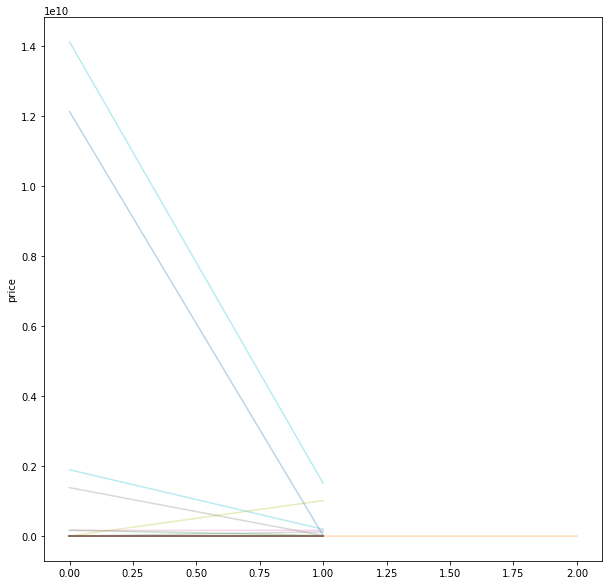

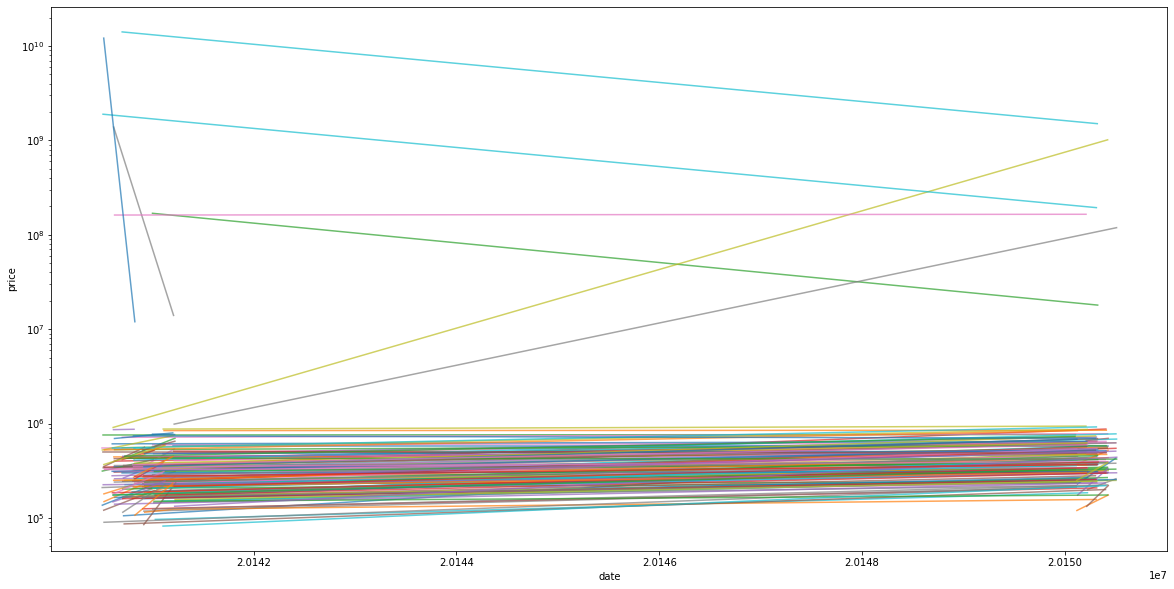

In [ ]:
plt.figure(figsize=(10,10))

for id in set(duplicates['id']):
    X = range(0, duplicates['id'].value_counts()[id], 1)
    sns.lineplot(y = (duplicates['price'][duplicates['id'] == id]), x = X, alpha = 0.3)

plt.show()

###___________________________________________________________________###

plt.figure(figsize=(20,10))

for id in set(duplicates['id']):
    sns.lineplot(y = duplicates['price'][duplicates['id'] == id], x = duplicates['date'][duplicates['id'] == id], alpha = 0.7)

plt.yscale('log')
plt.show()

In [ ]:
roof_c['date']

0        20141013
1        20141209
2        20150225
3        20141209
4        20150218
           ...   
21608    20140521
21609    20150223
21610    20140623
21611    20150116
21612    20141015
Name: date, Length: 21613, dtype: int64

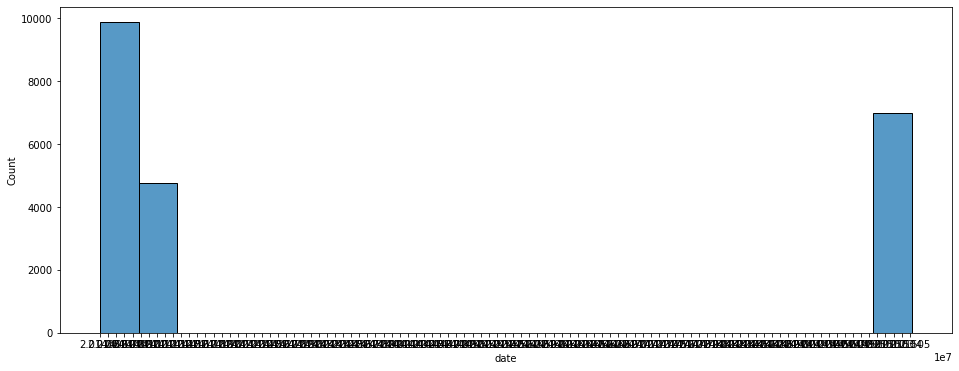

In [ ]:
plt.figure(figsize=(16,6))
sns.histplot(roof_c['date'], bins=21)
plt.xticks(range(min(roof_c['date']),max(roof_c['date']), 100))
plt.show()